<a href="https://colab.research.google.com/github/spyrgalaz/DNN_RK/blob/main/TIME_SERIES_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 427_days.csv to 427_days.csv


In [ ]:
import io

In [ ]:
import pandas as pd
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df = pd.read_csv('427_days.csv',sep='\t')
print(df.head())


        DOS,  Message Count
0  2018-9-1,             25
1  2018-9-2,            192
2  2018-9-3,           1190
3  2018-9-4,            918
4  2018-9-5,           1090


In [ ]:
df['DOS,']=df['DOS,'].replace({',':''},regex=True)
df['DOS,']= pd.to_datetime(df['DOS,'])
df.set_index("DOS,", inplace = True)
print(df.head())


            Message Count
DOS,                     
2018-09-01             25
2018-09-02            192
2018-09-03           1190
2018-09-04            918
2018-09-05           1090


In [ ]:
s_count = np.array( df['Message Count'])
time_step = np.arange(len(df.index))


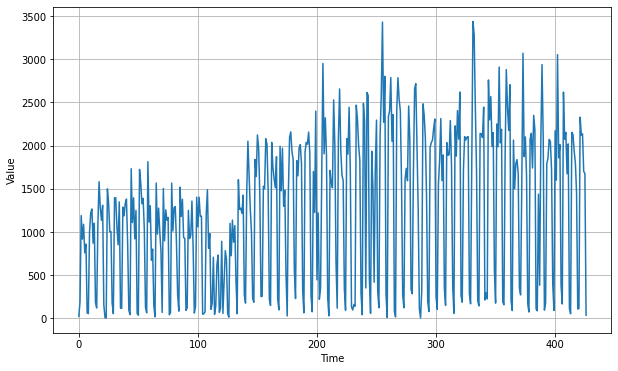

In [ ]:
#time_step = []
#s_count = []

series = np.array(s_count)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 340
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 14
batch_size = 32
shuffle_buffer_size = 30



In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 35
batch_size = 32
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 4000)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.int64, tf.int64)>
(340,)
Epoch 1/100
10/10 [==============================] - 32s 13ms/step - loss: 896.9572 - mae: 897.4572
Epoch 2/100
10/10 [==============================] - 0s 9ms/step - loss: 859.4410 - mae: 859.9409
Epoch 3/100
10/10 [==============================] - 0s 9ms/step - loss: 816.4964 - mae: 816.9964
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 770.7249 - mae: 771.2249
Epoch 5/100
10/10 [==============================] - 0s 9ms/step - loss: 727.4473 - mae: 727.9472
Epoch 6/100
10/10 [==============================] - 0s 8ms/step - loss: 686.4709 - mae: 686.9709
Epoch 7/100
10/10 [==============================] - 0s 9ms/step - loss: 654.6641 - mae: 655.1641
Epoch 8/100
10/10 [==============================] - 0s 9ms/step - loss: 626.1316 - mae: 626.6315
Epoch 9/100
10/10 [==============================] - 0s 9ms/step - loss: 604.2920 - mae: 604.7916
Epoch 10/100
10/10 

(1e-08, 0.0001, 0.0, 1000.0)

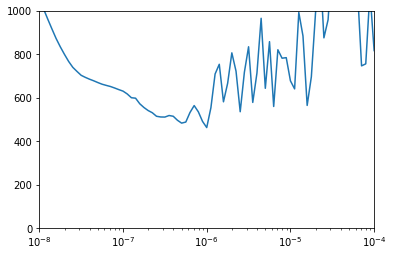

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 1000])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=100, batch_size=50, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 4000)
])


optimizer = tf.keras.optimizers.SGD(lr=8e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=420)

Epoch 1/420
5/5 [==============================] - 3s 24ms/step - loss: 1054.9583 - mae: 1055.4583
Epoch 2/420
5/5 [==============================] - 0s 16ms/step - loss: 619.3798 - mae: 619.8790
Epoch 3/420
5/5 [==============================] - 0s 16ms/step - loss: 741.0972 - mae: 741.5971
Epoch 4/420
5/5 [==============================] - 0s 14ms/step - loss: 583.0141 - mae: 583.5141
Epoch 5/420
5/5 [==============================] - 0s 16ms/step - loss: 578.1344 - mae: 578.6343
Epoch 6/420
5/5 [==============================] - 0s 16ms/step - loss: 553.5828 - mae: 554.0818
Epoch 7/420
5/5 [==============================] - 0s 16ms/step - loss: 541.0215 - mae: 541.5210
Epoch 8/420
5/5 [==============================] - 0s 17ms/step - loss: 541.0619 - mae: 541.5615
Epoch 9/420
5/5 [==============================] - 0s 17ms/step - loss: 497.4974 - mae: 497.9972
Epoch 10/420
5/5 [==============================] - 0s 16ms/step - loss: 499.1183 - mae: 499.6181
Epoch 11/420
5/5 [=========

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

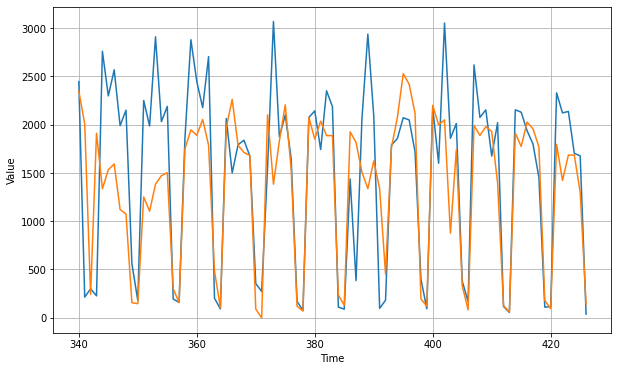

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

441.01285

<Figure size 432x288 with 0 Axes>

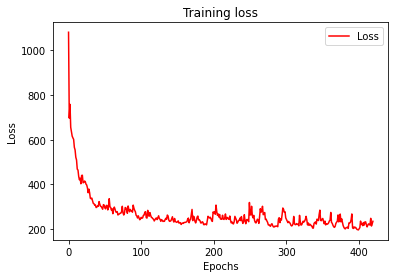

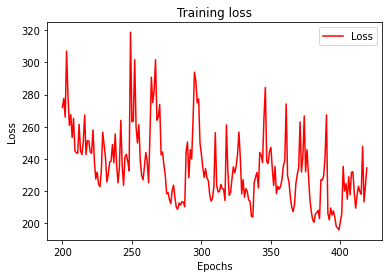

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,420)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)

[2171.6577   1879.5619    160.45474  2104.1099   1425.8838   1623.5122
 1412.5576    905.2752    488.78265    37.048817  -70.43946  1224.7056
 1455.3385   1703.0162   1648.2024   1517.6625    203.17587    66.553444
 1610.7047   1824.774    2144.7278   1549.3822   1112.6323    148.66125
   56.704937 1480.2386   1756.8324   1351.687    1335.1095   1424.0234
  204.1881     54.49933  1574.8634   1804.3246   2432.7625   2329.743
 1945.9896    332.12622   292.6746   2271.5073   2299.2317   2131.8796
 2373.3318   2082.6226    217.37042    95.253914 1645.8425   1883.1687
 1474.5946   1207.304    1182.1764   1356.7867    203.44841  1712.0056
 1838.46     2115.657    1867.3768   1698.8108    206.40541    69.685104
 1671.403    1735.2831   1630.4469   1568.2635   1394.8372    213.66925
  104.48733  1681.7224   1298.9222   1090.6758   1173.7305   1038.9845
  130.88718    35.10067  1425.9766   1589.2181   1806.7042   1924.1025
 1679.0524    129.13301    12.869417 1850.9534   1078.0055   1256.9719
 